In [31]:
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import math
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [2]:
train_data = pd.read_csv("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Original Data\\train.csv")
test_data = pd.read_csv("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Original Data\\test.csv")

In [51]:
train_data.shape

(201917, 6)

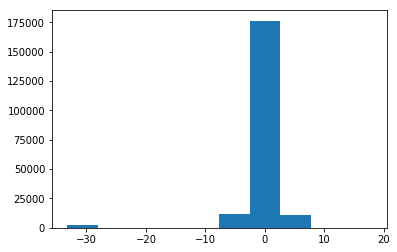

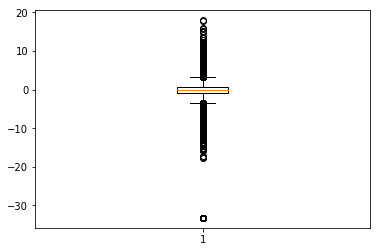

In [3]:
plt.hist(train_data['target'])
plt.show()

plt.boxplot(train_data['target'])
plt.show()

In [4]:
def feature_concat(train_data1,filepath):
    for file in filepath:
        data_features = pd.read_csv(file)
        train_data1 = pd.merge(train_data1, data_features, how='left', on='card_id')
    return(train_data1)

In [6]:
def kfold_split(splitcount, train_data1, ignore_cols):  
    output_feature=['target']
    input_features=[x for x in train_data1.columns if x not in ['first_active_month', 'card_id','target','target_bin','month_max']]
    train_X = train_data1[input_features]
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    train_X = train_X.select_dtypes(include = numerics)
    train_y = train_data1[output_feature]
    kf = StratifiedKFold(n_splits=splitcount, random_state=2018, shuffle=True)
    counter=0
    models=[]
    splits={}
    for dev_index, val_index in kf.split(train_X,train_data1['target_bin']):
        dev_X, val_X = train_X.loc[dev_index, :], train_X.loc[val_index, :]
        dev_y, val_y = train_y.loc[dev_index], train_y.loc[val_index]
        splits[counter] = [dev_X, val_X,dev_y, val_y]
        counter=counter+1
    return splits

In [7]:
%%time
file_list = glob.glob("C:/Kaggle competetion datasets/Elo Merchent Category Recommendation/Elo Feb 18th/faetures_feb18th/*.csv")
train_features = feature_concat(train_data, file_list)

Wall time: 40.1 s


In [10]:
print(train_features.shape)

(201917, 318)


In [11]:
# Binning the numeric variable to different categories

target_std=train_features['target'].std()
max_target=train_features['target'].max()+1
min_target=train_features['target'].min()-1
bins=[min_target,-3*target_std,-2*target_std,-1*target_std,target_std*1,target_std*2,target_std*3,max_target]
labels=[-4,-3,-2,0,2,3,5]
train_features['target_bin']=pd.cut(train_features['target'],bins=bins,labels=labels).astype(int)
train_features['target_bin']=train_features['target_bin'].abs()
train_features.groupby(['target_bin']).size()

target_bin
0    191093
2      8200
3       363
4      2237
5        24
dtype: int64

In [12]:
kfolds = kfold_split(5, train_features, ['first_active_month', 'card_id','target','target_bin','month_max'])

In [18]:
kfolds

{0: [        feature_1  feature_2  feature_3  active_first  merc_count_perc  \
  0               5          2          1            26         0.070175   
  1               4          1          0             5         0.036145   
  2               2          2          0           163         0.076923   
  4               1          3          0            11         0.024390   
  6               3          2          1            35         0.059172   
  7               3          2          1            27         0.125000   
  8               2          1          0            17         0.090909   
  9               2          2          0           161         0.072917   
  10              5          2          1           184         0.075000   
  11              2          2          0           311         0.333333   
  12              5          2          1            11         0.173913   
  15              2          1          0            18         0.097345   
  16     

In [70]:
# xgb_model = xgb.XGBRegressor(booster='gbtree',nthread=2,learning_rate=0.01,max_depth=10,min_child_weight=177,subsample=0.8)
param = {'nthread':-1,'learning_rate':0.01,'max_depth':8,'min_child_weight':177,'subsample':0.8,
        'num_boost_round':2000,'early_stopping_rounds':200,'verbose_eval':100, 'eval_metric':'rmse', 'obj':'reg:linear'}

# xgb_model = xgb.XGBRegressor(booster='gbtree',nthread=2,learning_rate=0.01,max_depth=14,min_child_weight=100,subsample=0.7)
# xgb_model = xgb.XGBRegressor(booster='gblinear',reg_lambda=0.7,reg_alpha =0.3)
models = []
for split in kfolds.keys():
    dtrain = xgb.DMatrix(kfolds[split][0].values, label=kfolds[split][2].values)
    dvalid = xgb.DMatrix(kfolds[split][1].values, label=kfolds[split][3].values)
    evallist = [(dtrain, 'train'), (dvalid, 'eval')]
    xgb_model = xgb.train(params = param, evals = evallist, dtrain = dtrain)
    # xgb_model_pred = xgb_model.predict(kfolds[split][0].values, kfolds[split][2].values)
    models.append(xgb_model)

[0]	train-rmse:3.94852	eval-rmse:3.94316
[1]	train-rmse:3.94313	eval-rmse:3.93814
[2]	train-rmse:3.93802	eval-rmse:3.93349
[3]	train-rmse:3.93292	eval-rmse:3.92888
[4]	train-rmse:3.92771	eval-rmse:3.92406
[5]	train-rmse:3.92258	eval-rmse:3.9194
[6]	train-rmse:3.91771	eval-rmse:3.91489
[7]	train-rmse:3.91282	eval-rmse:3.91037
[8]	train-rmse:3.90798	eval-rmse:3.90586
[9]	train-rmse:3.90321	eval-rmse:3.90165
[0]	train-rmse:3.94519	eval-rmse:3.95716
[1]	train-rmse:3.93989	eval-rmse:3.95235
[2]	train-rmse:3.93466	eval-rmse:3.9476
[3]	train-rmse:3.92949	eval-rmse:3.9429
[4]	train-rmse:3.92447	eval-rmse:3.93833
[5]	train-rmse:3.91956	eval-rmse:3.93396
[6]	train-rmse:3.91455	eval-rmse:3.92941
[7]	train-rmse:3.90975	eval-rmse:3.92509
[8]	train-rmse:3.90498	eval-rmse:3.92082
[9]	train-rmse:3.90035	eval-rmse:3.91669
[0]	train-rmse:3.94744	eval-rmse:3.94768
[1]	train-rmse:3.94206	eval-rmse:3.9426
[2]	train-rmse:3.93683	eval-rmse:3.93764
[3]	train-rmse:3.93167	eval-rmse:3.93283
[4]	train-rmse:3.926

In [76]:
predictions = xgb_model.predict(kfolds[split][1].values)

math.sqrt(mean_squared_error(predictions, kfolds[split][3]))

AttributeError: 'numpy.ndarray' object has no attribute 'feature_names'

In [74]:
kfolds[split][1].values

array([[ 2.        ,  2.        ,  0.        , ...,  1.        ,
                nan,         nan],
       [ 5.        ,  2.        ,  1.        , ...,  2.        ,
         0.        ,  0.        ],
       [ 2.        ,  2.        ,  0.        , ...,  1.        ,
                nan,         nan],
       ...,
       [ 3.        ,  3.        ,  1.        , ...,  2.        ,
        40.5       ,  6.36396103],
       [ 3.        ,  3.        ,  1.        , ...,  1.        ,
                nan,         nan],
       [ 5.        ,  1.        ,  1.        , ...,  2.        ,
         0.5       ,  0.70710678]])

In [49]:
dvalid.feature_names

['f0',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'f9',
 'f10',
 'f11',
 'f12',
 'f13',
 'f14',
 'f15',
 'f16',
 'f17',
 'f18',
 'f19',
 'f20',
 'f21',
 'f22',
 'f23',
 'f24',
 'f25',
 'f26',
 'f27',
 'f28',
 'f29',
 'f30',
 'f31',
 'f32',
 'f33',
 'f34',
 'f35',
 'f36',
 'f37',
 'f38',
 'f39',
 'f40',
 'f41',
 'f42',
 'f43',
 'f44',
 'f45',
 'f46',
 'f47',
 'f48',
 'f49',
 'f50',
 'f51',
 'f52',
 'f53',
 'f54',
 'f55',
 'f56',
 'f57',
 'f58',
 'f59',
 'f60',
 'f61',
 'f62',
 'f63',
 'f64',
 'f65',
 'f66',
 'f67',
 'f68',
 'f69',
 'f70',
 'f71',
 'f72',
 'f73',
 'f74',
 'f75',
 'f76',
 'f77',
 'f78',
 'f79',
 'f80',
 'f81',
 'f82',
 'f83',
 'f84',
 'f85',
 'f86',
 'f87',
 'f88',
 'f89',
 'f90',
 'f91',
 'f92',
 'f93',
 'f94',
 'f95',
 'f96',
 'f97',
 'f98',
 'f99',
 'f100',
 'f101',
 'f102',
 'f103',
 'f104',
 'f105',
 'f106',
 'f107',
 'f108',
 'f109',
 'f110',
 'f111',
 'f112',
 'f113',
 'f114',
 'f115',
 'f116',
 'f117',
 'f118',
 'f119',
 'f120',
 'f121',
 'f122',
 'f

In [65]:
kfolds[split][0].shape

(161532, 310)

In [61]:
kfolds[split][0].head()

,feature_1,feature_2,feature_3,active_first,merc_count_perc,cate_count_perc,amount_perc,trx_count_perc,authorized_sum_x,city_id_nunique_x,...,purchase_amount1_mean_y,purchase_amount1_count_y,purchase_amount1_var_y,purchase_amount1_std_y,purchase_count_min_y,purchase_count_max_y,purchase_count_mean_y,purchase_count_count_y,purchase_count_var_y,purchase_count_std_y
0,5,2,1,26,0.070175,0.103448,0.040318,0.950000,23.0,3.0,...,1.967339,2.0,0.186693,0.432080,11.0,12.0,11.5,2.0,0.5,0.707107
1,4,1,0,5,0.036145,0.048913,0.137967,0.968571,6.0,1.0,...,0.062856,2.0,0.001437,0.037911,3.0,3.0,3.0,2.0,0.0,0.000000
2,2,2,0,163,0.076923,0.090909,0.052497,0.953488,1.0,1.0,...,0.046582,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN
4,1,3,0,11,0.024390,0.047619,0.466260,0.962406,36.0,5.0,...,3.481222,2.0,2.583675,1.607381,16.0,20.0,18.0,2.0,8.0,2.828427
6,3,2,1,35,0.059172,0.091743,0.050275,0.934615,5.0,1.0,...,0.065966,2.0,0.003856,0.062095,1.0,4.0,2.5,2.0,4.5,2.121320


In [66]:
kfolds[split][1].shape

(40385, 310)

In [62]:
kfolds[split][1].head()

,feature_1,feature_2,feature_3,active_first,merc_count_perc,cate_count_perc,amount_perc,trx_count_perc,authorized_sum_x,city_id_nunique_x,...,purchase_amount1_mean_y,purchase_amount1_count_y,purchase_amount1_var_y,purchase_amount1_std_y,purchase_count_min_y,purchase_count_max_y,purchase_count_mean_y,purchase_count_count_y,purchase_count_var_y,purchase_count_std_y
3,4,3,0,25,NaN,NaN,NaN,NaN,7.0,2.0,...,0.286991,2.0,0.011340,0.106487,2.0,5.0,3.5,2.0,4.5,2.121320
5,4,2,0,131,0.032258,0.038462,0.012439,0.969697,4.0,1.0,...,0.793783,2.0,0.205586,0.453416,1.0,3.0,2.0,2.0,2.0,1.414214
13,2,1,0,0,NaN,NaN,NaN,NaN,4.0,3.0,...,0.505958,1.0,NaN,NaN,4.0,4.0,4.0,1.0,NaN,NaN
14,3,2,1,8,0.062500,0.088235,0.127622,0.892308,6.0,1.0,...,0.398721,2.0,0.181894,0.426491,2.0,4.0,3.0,2.0,2.0,1.414214
17,4,2,0,44,0.034483,0.055556,0.016789,0.975610,1.0,1.0,...,0.107139,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN


In [67]:
kfolds[split][2].shape

(161532, 1)

In [63]:
kfolds[split][2].head()

,target
0,-0.820283
1,0.392913
2,0.688056
4,-0.159749
6,0.230129


In [64]:
kfolds[split][3].head()

,target
3,0.142495
5,0.871585
13,0.093633
14,1.597750
17,0.318062
